<a href="https://colab.research.google.com/github/dayeon24/24-1_ML-HW/blob/main/HW01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 4.1 선형 회귀

1. 선형 데이터를 생성하는 과정

  y = 4 + 3x 를 따르며 손떨림(난수)을 보정해서 넣은 데이터


In [1]:
import numpy as np

np.random.seed(42)  # 난수 생성 패턴을 고정하는 함수, 코드 예제 숫자들의 재현 가능
m = 100  # 샘플 개수

# np.random.randn(m, 1)은 평균 0, 표준편차 1의 정규 분포를 따르는 난수를 생성
X = 2 * np.random.rand(m, 1)  # m개 난수 생성 -> 2를 곱하여 열 벡터형태로 X에 저장
y = 4 + 3 * X + np.random.randn(m, 1)  # 난수를 이용해 열 벡터생성, y=3X+4+난수(가우스 노이즈)
X.shape, y.shape #((100, 1), (100, 1))

((100, 1), (100, 1))

2. 선형 회귀 모델을 예측하는 과정

  MSE를 최소화하는 파라메터(세타)
  

In [2]:
from sklearn.preprocessing import add_dummy_feature #상수항 추가하는 함수

X_b = add_dummy_feature(X) #데이터의 맨 앞 열에 1(bias)로 채워진 열을 추가
# X.shape, X_b.shape 실행결과 (100, 1),(100, 2)

# np.linalg : 선형 대수 연산 수행 가능한 함수
# np.linalg.inv : 역행렬 계산
# @ : np.matmul(A,B)와 동일, 행렬 곱셈
# T : 전치 행렬

theta_best = np.linalg.inv(X_b.T @ X_b) @ X_b.T @ y # 식 4-4 구현, 비용 함수를 최소화하는 파라메터를 찾는 식

In [3]:
theta_best # 순서대로 세타0 세타1

array([[4.21509616],
       [2.77011339]])

3. 샘플(2개)에 대한 모델의 예측 값(y)

In [4]:
X_new = np.array([[0], [2]]) # 샘플 2개, x값
X_new_b = add_dummy_feature(X_new)  # 각 샘플에 x0 = 1을 추가합니다. 모델의 상수항을 고려하기 위함
y_predict = X_new_b @ theta_best # 샘플 2개에 대한 예측값
y_predict

array([[4.21509616],
       [9.75532293]])

4. 예측한 모델 그래프로 표현

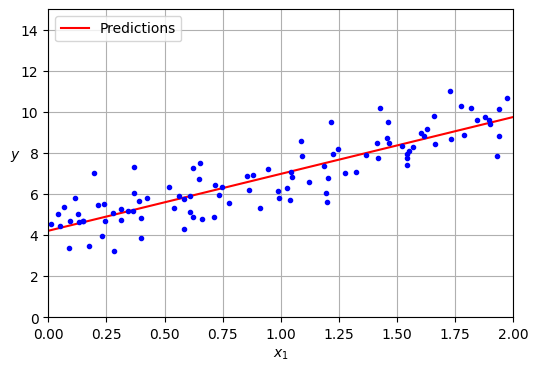

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))  # figure생성하고 크기 설정
#입력 데이터 X_new에 대한 예측값 y_predict에 대한 빨간색 실선(모델) 그리기
plt.plot(X_new, y_predict, "r-", label="Predictions")
#원래 데이터 x에 대한 타겟값 y을 파란색 점으로 그리기
plt.plot(X, y, "b.")

#x축과 y축에 라벨을 설정
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
#x축과 y축에 라벨을 설정
plt.axis([0, 2, 0, 15])
plt.grid()
plt.legend(loc="upper left")

plt.show()

5. 사이킷런에서 선형회귀 수행

  add_dummy_feature() 및 정규방정식 선언 필요없이 LinearRegression() 간단히 수행

In [6]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression() #선형 회귀 모델 선언
lin_reg.fit(X, y) #입력 데이터 X와 타겟 데이터 y에 대해 모델 훈련

# 훈련된 모델의 절편(intercept, bias)과 계수(coefficient, feature 가중치)를 반환
lin_reg.intercept_, lin_reg.coef_

(array([4.21509616]), array([[2.77011339]]))

In [7]:
lin_reg.predict(X_new) # y_predict와 값이 동일하다

array([[4.21509616],
       [9.75532293]])

In [8]:
# Least Squares Method 기반

# 순서대로 최적의 파라미터,  잔차(오차)의 제곱의 합, 특징 행렬의 랭크(rank), singular values 값
theta_best_svd, residuals, rank, s = np.linalg.lstsq(X_b, y, rcond=1e-6) # SVD 임계값 1e-6
theta_best_svd

array([[4.21509616],
       [2.77011339]])

In [9]:
# 무어-펜로즈 유사역행렬(pseudoinverse)
np.linalg.pinv(X_b) @ y

array([[4.21509616],
       [2.77011339]])

# 4.2 경사 하강법

6. 정사 하강법을 이용한 학습법

  앞서 공부한 정규 방정식이나 SVD 방법 모두 특성 수가 많아지면 계산 시간이 배가 된다.
  
  이에 대한 해법으로 학습률(하이퍼파라미터)을 이용해 비용 함수를 최소화한다.
  
  편도함수를 반복 계산하여 파라미터를 업데이트한다.

In [10]:
eta = 0.1  # 학습률, 파라미터를 업데이트를 얼마나 할지
n_epochs = 1000 # 전체 데이터셋을 1000번 반복하여 학습
m = len(X_b)  # 샘플 개수 100

np.random.seed(42) # 결과값 재현을 위한 시드 설정

# 정규분포로부터 무작위 추출, 2개의 행과 1개의 열로 이뤄진 2차원 배열(bias, weight)
theta = np.random.randn(2, 1)  # 모델 파라미터를 랜덤하게 초기화

for epoch in range(n_epochs):
    gradients = 2 / m * X_b.T @ (X_b @ theta - y) # 식 4-6 비용 함수의 그레이디언트 벡터
    theta = theta - eta * gradients # 식 4-7 경사 하강법으로 세타 업데이트

In [11]:
# 1000번 반복 학습하여 SD 방법으로 theta를 최적화한 결과 앞선 결과와 동일하다.
theta

array([[4.21509616],
       [2.77011339]])

7. 확률적 경사 하강법

  매 스텝에서 전체 훈련 세트가 아닌 한 개의 샘플을 랜덤으로 선택하여 그 샘플에 대한 그레이디언트를 계산하는 방법이다.

  전역 최솟값에 다다르지 못한다는 한계를 극복하기 위해 어닐링을 진행한다. ( 학습 스케줄 이용 )

In [12]:
n_epochs = 50 # 학습데이터셋을 50번 반복 학습
t0, t1 = 5, 50  # 학습 스케줄 하이퍼파라미터

# 에포크와 반복 횟수에 따라 감소하는 방향으로 학습률을 계산하는 함수
def learning_schedule(t):
    return t0 / (t + t1)

np.random.seed(42)
theta = np.random.randn(2, 1)  # 랜덤 초기화


for epoch in range(n_epochs): # 50번 반복
    for iteration in range(m): # 샘플 수 만큼 100번 반복
      random_index = np.random.randint(m) # 0부터 m 사이의 무작위 정수 반환
      xi = X_b[random_index : random_index + 1] # random_index+1번째 샘플 x
      yi = y[random_index : random_index + 1] # random_index+1번째 샘플 y
      gradients = 2 * xi.T @ (xi @ theta - yi)  # 해당 한 샘플에 대해 gradients 계산
      eta = learning_schedule(epoch * m + iteration) # 학습율 계산
      theta = theta - eta * gradients # 계산한 학습율 만큼만 gradient를 반영하여 theta 업데이트

In [13]:
theta # 파라메터가 잘 학습된 것을 확인

array([[4.21076011],
       [2.74856079]])

8. SGDRegressor() 으로 확률적 경사 하강법 사용하기

In [14]:
from sklearn.linear_model import SGDRegressor

# SGD 모델 선언
# 최대 반복횟수 1000
# loss 변화량이 1e-5 값보다 작아지면 수렴되었다고 판단하고 종료
# 정규화(L1, L2)를 사용하지 않음
# 학습률은 0.01
# loss가 수렴되지않았어도 100회 학습하는 동안 개선되지않으면 조기 종료
# 시드값 고정
sgd_reg = SGDRegressor(max_iter=1000, tol=1e-5, penalty=None, eta0=0.01,
                       n_iter_no_change=100, random_state=42)

# 학습
sgd_reg.fit(X, y.ravel())  # fit()이 1D 타깃을 기대 -> y.ravel(), 다차원 배열을 1차원 배열로 전환 후 전달

SGDRegressor(n_iter_no_change=100, penalty=None, random_state=42, tol=1e-05)

In [15]:
# bias와 파라미터가 근사하게 맞춘 것을 확인 할 수 있다.
sgd_reg.intercept_, sgd_reg.coef_

(array([4.21278812]), array([2.77270267]))

# 4.3 다항 회귀

In [16]:
# 위와 동일하게 잡음을 포함한 비선형 데이터 셋을 만드는 과정
np.random.seed(42) # 시드 고정
m = 100 # 샘플 수
X = 6 * np.random.rand(m, 1) - 3 # 샘플수에 해당하는 난수 생성 * 6
y = 0.5 * X ** 2 + X + 2 + np.random.randn(m, 1) # ax^2 + bx + c

In [17]:
from sklearn.preprocessing import PolynomialFeatures

# 다항식 차수 degree는 2, 다항식 모델 선언
poly_features = PolynomialFeatures(degree=2, include_bias=False)
# 현재 학습 데이터 X를 fit_transform 하여 다항식에 맞는 특성 행렬생성
X_poly = poly_features.fit_transform(X)
# 첫번째 샘플의 특성 벡터
X[0]

array([-0.75275929])

In [18]:
X_poly[0]

array([-0.75275929,  0.56664654])

In [19]:
lin_reg = LinearRegression()# 선형회귀모델 선언
lin_reg.fit(X_poly, y) # 다항식 특성 벡터를 x로한 y에 대하여 학습
lin_reg.intercept_, lin_reg.coef_ # bias와 두 개(2차식) 파라메터 추정 결과

#1.0을 0.93366893, 0.5을 0.56456263으로 정답을 근사하게 예측함

(array([1.78134581]), array([[0.93366893, 0.56456263]]))

# 4.4 학습 곡선

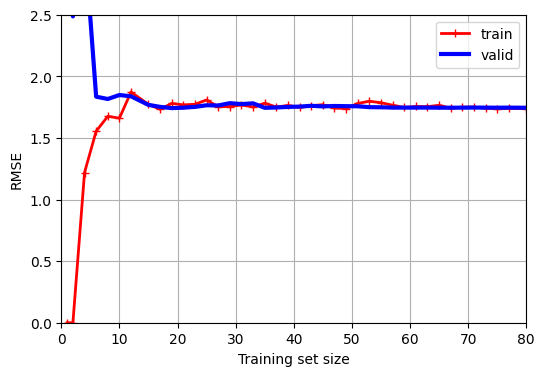

In [20]:
from sklearn.model_selection import learning_curve

# 교차 검증을 사용하여 모델을 훈련하고 평가하는 함수
# X, y 데이터로 학습하는 LinearRegression 모델에 대하여 평가
# 5-fold crass validation
# 0.01부터 1.0까지 범위내에서 40개의 값을 생성, 훈련 데이터 크기
# 평가 지표는 평균 제곱근 오차의 음수 값(값이 클 수록 성능이 좋다는 뜻)
train_sizes, train_scores, valid_scores = learning_curve(
    LinearRegression(), X, y, train_sizes=np.linspace(0.01, 1.0, 40), cv=5,
    scoring="neg_root_mean_squared_error")

# learning_curve 함수를 사용하여 얻은 훈련 점수와 검증 점수를 바탕으로 훈련 오차와 검증 오차를 계산
# 각 행은 각 훈련 세트 크기에 대응되는 점수이며, 각 행의 평균을 계산
train_errors = -train_scores.mean(axis=1)
valid_errors = -valid_scores.mean(axis=1)

# figure를 생성
plt.figure(figsize=(6, 4))
# 훈련 오차는 빨간색
plt.plot(train_sizes, train_errors, "r-+", linewidth=2, label="train")
# 검증 오차를 파란색으로 표시
plt.plot(train_sizes, valid_errors, "b-", linewidth=3, label="valid")

plt.xlabel("Training set size") # x축 라벨
plt.ylabel("RMSE") # y축 라벨
plt.grid() # 격자를 표시
plt.legend(loc="upper right") # 범례를 우측 상단에
plt.axis([0, 80, 0, 2.5]) # x축과 y축의 범위를 설정

plt.show() # 그리기

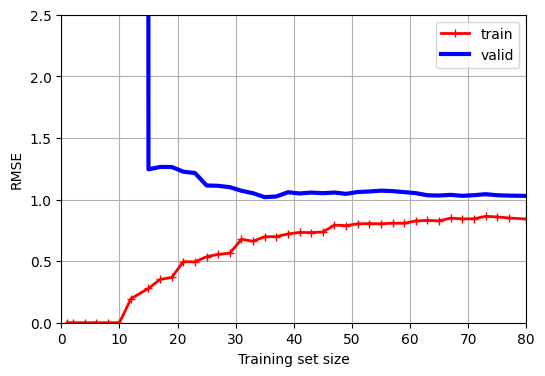

In [21]:
from sklearn.model_selection import learning_curve
from sklearn.pipeline import make_pipeline

# polynomial_regression 모델 선언
# 10차 다항식 특성을 생성하고, 해당 데이터에 대해 LinearRegression 수행
polynomial_regression = make_pipeline(
    PolynomialFeatures(degree=10, include_bias=False),
    LinearRegression())

# 교차 검증을 사용하여 모델을 훈련하고 평가하는 함수
train_sizes, train_scores, valid_scores = learning_curve(
    polynomial_regression, X, y, train_sizes=np.linspace(0.01, 1.0, 40), cv=5,
    scoring="neg_root_mean_squared_error")

# learning_curve 함수를 사용하여 얻은 훈련 점수와 검증 점수를 바탕으로 훈련 오차와 검증 오차를 계산
train_errors = -train_scores.mean(axis=1)
valid_errors = -valid_scores.mean(axis=1)

# figure를 생성
plt.figure(figsize=(6, 4))
# 훈련 오차는 빨간색
plt.plot(train_sizes, train_errors, "r-+", linewidth=2, label="train")
# 검증 오차를 파란색으로 표시
plt.plot(train_sizes, valid_errors, "b-", linewidth=3, label="valid")

plt.xlabel("Training set size") # x축 라벨
plt.ylabel("RMSE") # y축 라벨
plt.grid() # 격자를 표시
plt.legend(loc="upper right") # 범례를 우측 상단에
plt.axis([0, 80, 0, 2.5]) # x축과 y축의 범위를 설정

plt.show() # 그리기

# 4.5 규제가 있는 선형 모델
  
  릿지 회귀


In [22]:
from sklearn.linear_model import Ridge

# Ridge 회귀 모델을 생성
# 정규화를 조절 값 alpha, 숄레스키 분해를 사용해 최적화
ridge_reg = Ridge(alpha=0.1, solver="cholesky")
ridge_reg.fit(X, y) # 학습, 최적의 선형 함수를 찾는 과정
ridge_reg.predict([[1.5]]) # 특정 값 [1.5]에 대한 예측

array([[4.82899748]])

In [23]:
# SGD 회귀 모델을 생성
# 0.1 / m 강도의 L2 정규화 사용
sgd_reg = SGDRegressor(penalty="l2", alpha=0.1 / m, tol=None,
                       max_iter=1000, eta0=0.01, random_state=42)
sgd_reg.fit(X, y.ravel())  # 2차원을 1차원 배열로 반환
sgd_reg.predict([[1.5]]) # 특정 값 [1.5]에 대한 예측

array([4.82830117])